In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, \
    confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from lightgbm import LGBMClassifier
import shap
from scipy.stats import mannwhitneyu

from src.datamanager import DataManager
from src.modelmanager import ModelManager, Optimizer, Param

In [2]:
%load_ext autoreload
%autoreload 2

### Configure analysis and hyperparameter tuning

In [3]:
data_filepath = './data/sepsis_updated_data_Feb21-Sep24_v2.csv'
y_label = 'bc_positive_or_diagnosis_or_cause_of_death'
seed = 41
n_trials = 64
columns_of_interest = ['Apgar1', 'Apgar5', 'Age', 'Gender',
       'Satsair', 'Typebirth', 'Romlength', 
       'Gestation', 'Birthweight', 'Temperature', 'Skin',
       'Dangersigns', 'Signsrd', 'Wob', 'Activity', 'Umbilicus', 'Colour',
       'Rr', 'Vomiting', 'Abdomen', 'Fontanelle', 'Hr']

Initial analysis: model comparison

In [4]:
main_model_managers = []

lr_manager = ModelManager('lr', 
                          y_label,
                          data_filepath,
                          columns_of_interest,
                          seed, 
                          LogisticRegression,
                          clf_params={'penalty': None, 'max_iter': 10000})
lr_manager.run()
main_model_managers.append(lr_manager)

knn_search_space = [
    Param('n_neighbors', 'suggest_int', (8, 512))
]

knn_manager = ModelManager('knn',
                           y_label,
                           data_filepath,
                           columns_of_interest,
                           seed,
                           KNeighborsClassifier,
                           n_trials,
                           search_space=knn_search_space,
                           clf_params={'n_jobs': -1})

knn_manager.run()
main_model_managers.append(knn_manager)

lgbm_search_space = [
    Param('max_depth', 'suggest_int', (0, 20)),
    Param('min_data_in_leaf', 'suggest_int', (10, 30)),
    Param('reg_alpha', 'suggest_float', (0, 10)),
    Param('min_split_gain', 'suggest_float', (0, 1)),
    Param('num_leaves', 'suggest_int', (2, 31))
]
lgb_manager = ModelManager('lgb',
                           y_label,
                           data_filepath,
                           columns_of_interest,
                           seed,
                           LGBMClassifier,
                           n_trials,
                           search_space=lgbm_search_space,
                           clf_params={'objective': 'binary', 'verbosity': -1})
lgb_manager.run()
main_model_managers.append(lgb_manager)
    

/hpchome/ccaeelo@IDHS.UCL.AC.UK/projects/neotree-report/src/datamanager.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df.assign(Neolab_datebct    = pd.to_datetime(df['Neolab_datebct'],    utc=True),
/hpchome/ccaeelo@IDHS.UCL.AC.UK/projects/neotree-report/src/datamanager.py:97: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Datetimedeath     = pd.to_datetime(df['Datetimedeath'],     utc=True))


18345
18345


/hpchome/ccaeelo@IDHS.UCL.AC.UK/projects/neotree-report/src/datamanager.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df.assign(Neolab_datebct    = pd.to_datetime(df['Neolab_datebct'],    utc=True),
/hpchome/ccaeelo@IDHS.UCL.AC.UK/projects/neotree-report/src/datamanager.py:97: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Datetimedeath     = pd.to_datetime(df['Datetimedeath'],     utc=True))


18345


[I 2025-03-06 16:38:55,399] A new study created in memory with name: no-name-fd52dffb-cddb-4551-a0a8-55981454784b


18345


[I 2025-03-06 16:38:57,738] Trial 0 finished with value: 0.6858802634430896 and parameters: {'n_neighbors': 225}. Best is trial 0 with value: 0.6858802634430896.
[I 2025-03-06 16:38:58,288] Trial 1 finished with value: 0.6825705987686732 and parameters: {'n_neighbors': 125}. Best is trial 0 with value: 0.6858802634430896.
[I 2025-03-06 16:38:59,445] Trial 2 finished with value: 0.6916630395477076 and parameters: {'n_neighbors': 477}. Best is trial 2 with value: 0.6916630395477076.
[I 2025-03-06 16:39:00,144] Trial 3 finished with value: 0.6868110435914985 and parameters: {'n_neighbors': 212}. Best is trial 2 with value: 0.6916630395477076.
[I 2025-03-06 16:39:01,217] Trial 4 finished with value: 0.6925329216843784 and parameters: {'n_neighbors': 442}. Best is trial 4 with value: 0.6925329216843784.
[I 2025-03-06 16:39:01,570] Trial 5 finished with value: 0.6133238717096141 and parameters: {'n_neighbors': 17}. Best is trial 4 with value: 0.6925329216843784.
[I 2025-03-06 16:39:02,605] T

18345


[I 2025-03-06 16:40:43,747] A new study created in memory with name: no-name-f49d7693-0a2d-4f61-a2f7-a60f42e3aadc


18345


[I 2025-03-06 16:40:47,905] Trial 0 finished with value: 0.6991157629855033 and parameters: {'max_depth': 1, 'min_data_in_leaf': 13, 'reg_alpha': 0.6350530943737698, 'min_split_gain': 0.3523948492119181, 'num_leaves': 28}. Best is trial 0 with value: 0.6991157629855033.
[I 2025-03-06 16:40:51,601] Trial 1 finished with value: 0.7042681452551963 and parameters: {'max_depth': 15, 'min_data_in_leaf': 28, 'reg_alpha': 1.3490930168871074, 'min_split_gain': 0.7947411721915134, 'num_leaves': 3}. Best is trial 1 with value: 0.7042681452551963.
[I 2025-03-06 16:40:55,109] Trial 2 finished with value: 0.6957670436277515 and parameters: {'max_depth': 9, 'min_data_in_leaf': 26, 'reg_alpha': 9.996810513872772, 'min_split_gain': 0.4013859379892075, 'num_leaves': 4}. Best is trial 1 with value: 0.7042681452551963.
[I 2025-03-06 16:41:02,129] Trial 3 finished with value: 0.6992436095861376 and parameters: {'max_depth': 6, 'min_data_in_leaf': 14, 'reg_alpha': 1.381429497538218, 'min_split_gain': 0.9955

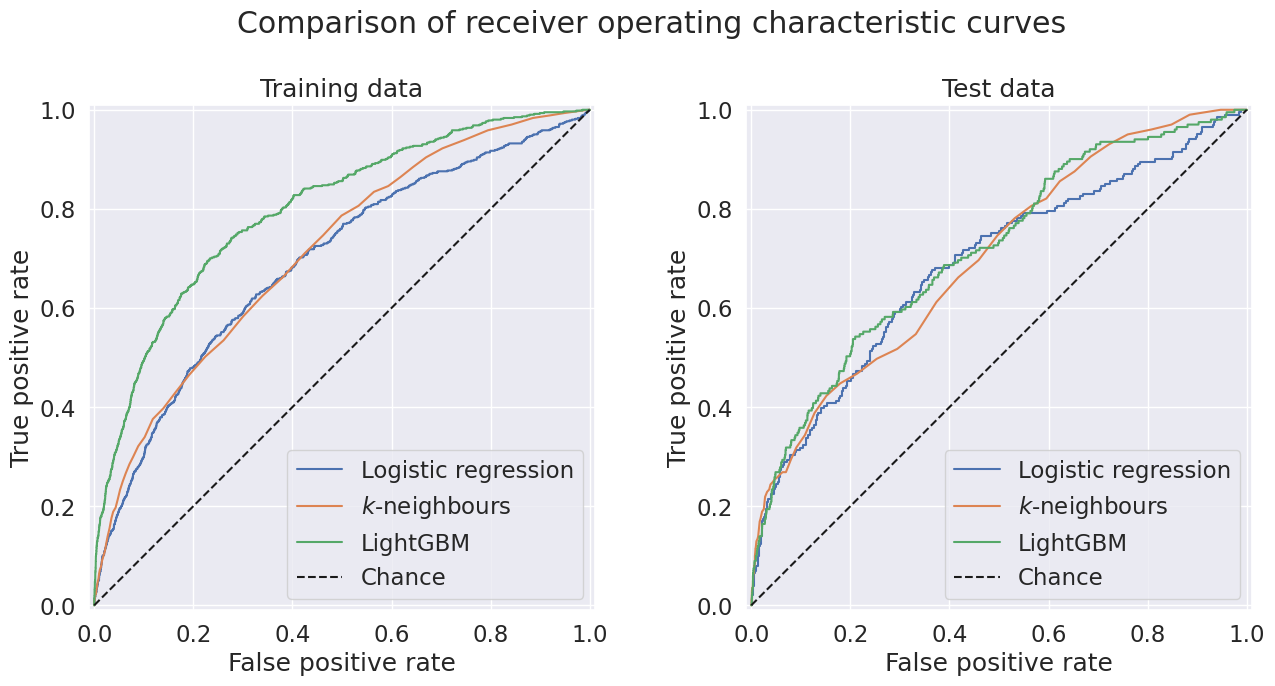

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
training_data_ax = axes[0]
test_data_ax = axes[1]

for mm in main_model_managers:
    if mm.name == 'knn':
        label = f'$k$-neighbours'
        RocCurveDisplay.from_predictions(mm.y_train,
                                         mm.best_clf.predict_proba(mm.X_train)[:,1], 
                                         ax=training_data_ax, 
                                         label=label)
        RocCurveDisplay.from_predictions(mm.y_test,
                                         mm.best_clf.predict_proba(mm.X_test)[:,1], 
                                         ax=test_data_ax, 
                                         label=label)
        
    elif mm.name == 'lgb':
        label = 'LightGBM'
        RocCurveDisplay.from_predictions(mm.y_train,
                                         mm.best_clf.predict_proba(mm.X_train)[:,1], 
                                         ax=training_data_ax, 
                                         label=label,
                                         plot_chance_level=True,
                                         chance_level_kw={'label':'Chance'})
        RocCurveDisplay.from_predictions(mm.y_test,
                                         mm.best_clf.predict_proba(mm.X_test)[:,1], 
                                         ax=test_data_ax, 
                                         label=label,
                                         plot_chance_level=True,
                                         chance_level_kw={'label':'Chance'})
    elif mm.name == 'lr': 
        label = 'Logistic regression'
        
        RocCurveDisplay.from_predictions(mm.y_train,
                                         mm.best_clf.predict_proba(mm.X_train)[:,1], 
                                         ax=training_data_ax, 
                                         label=label)
        RocCurveDisplay.from_predictions(mm.y_test,
                                         mm.best_clf.predict_proba(mm.X_test)[:,1], 
                                         ax=test_data_ax, 
                                         label=label)
for ax in axes:
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
training_data_ax.title.set_text('Training data')
test_data_ax.title.set_text('Test data')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
fig.suptitle('Comparison of receiver operating characteristic curves', y=0.93)
plt.savefig('./output/lr_knn_lgb_compared_v1.png', bbox_inches='tight', pad_inches=0.5)

In [6]:
model_comparison_rows = []
for mm in main_model_managers:
    model_comparison_rows.append({
        'label': mm.name,
        'metric': 'auroc',
        'type': 'train',
        'score': roc_auc_score(mm.y_train, mm.best_clf.predict_proba(mm.X_train)[:,1])
    })
    model_comparison_rows.append({
        'label': mm.name,
        'metric': 'auroc',
        'type': 'test',
        'score': roc_auc_score(mm.y_test, mm.best_clf.predict_proba(mm.X_test)[:,1])
    })
model_comparison_df = pd.DataFrame(model_comparison_rows)
model_comparison_df

,label,metric,type,score
0,lr,auroc,train,0.693565
1,lr,auroc,test,0.686863
2,knn,auroc,train,0.712859
3,knn,auroc,test,0.698885
4,lgb,auroc,train,0.798981
5,lgb,auroc,test,0.714002


In [7]:
model_comparison_df.loc[model_comparison_df['type'] == 'test']

,label,metric,type,score
1,lr,auroc,test,0.686863
3,knn,auroc,test,0.698885
5,lgb,auroc,test,0.714002


In [8]:
delong_dfs = []
for mm in main_model_managers:
    print(mm.name)
    print(mm.best_clf.predict_proba(mm.X_test)[:,-1])
    delong_dfs.append(pd.DataFrame({
        'name': mm.name,
        'y_test': mm.y_test.astype(int),
        'y_pred': mm.best_clf.predict_proba(mm.X_test)[:,-1]
    }))
delong_df = pd.concat(delong_dfs)
delong_df

lr
[0.03278835 0.08504529 0.01982656 ... 0.06413159 0.02659768 0.03959684]
knn
[0.05       0.0826087  0.00652174 ... 0.05       0.00652174 0.05652174]
lgb
[0.02268073 0.30456656 0.02021437 ... 0.06592018 0.02036254 0.02877838]


,name,y_test,y_pred
9334,lr,0,0.032788
15262,lr,0,0.085045
18569,lr,0,0.019827
18980,lr,0,0.007998
4673,lr,0,0.112575
...,...,...,...
97,lgb,0,0.018035
20552,lgb,0,0.043480
18646,lgb,0,0.065920
8303,lgb,0,0.020363


Output predictions for DeLong statistical test (performed separately using R)

In [9]:
delong_df.to_csv('./delong_df.csv', index=False)

In [10]:
import warnings

In [11]:
warnings.filterwarnings(
    'ignore', 
    category=UserWarning
)

In [12]:
pd.testing.assert_frame_equal(lr_manager.X_train, knn_manager.X_train)
pd.testing.assert_frame_equal(knn_manager.X_train, lgb_manager.X_train)
pd.testing.assert_frame_equal(lr_manager.X_test, knn_manager.X_test)
pd.testing.assert_frame_equal(knn_manager.X_test, lgb_manager.X_test)

Configure SHAP for explanations of variable importances:

In [13]:
X_train_representation = shap.kmeans(lr_manager.X_train, 4, round_values=False)

In [14]:
X_test_sample = lr_manager.X_test.sample(250)

for mm in main_model_managers:
    mm.explainer = shap.KernelExplainer(lambda X: mm.best_clf.predict_proba(X)[:,1], X_train_representation)
    mm.shap_values = mm.explainer(X_test_sample)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [15]:
dfs = []
for mm in main_model_managers:
    df = pd.DataFrame({
        'label': mm.name,
        'variable': mm.X_train.columns,
        'Mean absolute SHAP value': mm.shap_values.abs.mean(axis=0).values
    })
    dfs.append(df)
shap_df = pd.concat(dfs)

Make variable names more comprehensible for chart:

In [16]:
def expand_var_name(x):
    if x == 'Apgar1':
        return 'Apgar score at 1 minute'
    elif x == 'Apgar5':
        return 'Apgar score at 5 minutes'
    elif x == 'Satsair':
        return 'Oxygen saturation in air'
    elif x == 'Typebirth':
        return 'Type of birth'
    elif x == 'Romlength':
        return 'Premature rupture of membrane'
    elif x == 'Gestation':
        return 'Gestational age'
    elif x == 'Birthweight':
        return 'Birth weight'
    elif x == 'Skin':
        return 'Skin condition'
    elif x == 'Dangersigns':
        return 'Danger signs'
    elif x == 'Signsrd':
        return 'Signs of respiratory distress'
    elif x == 'Wob':
        return 'Work of breathing'
    elif x == 'Activity':
        return 'Alertness'
    elif x == 'Rr':
        return 'Respiratory rate'
    elif x == 'Abdomen':
        return 'Abdomen check'
    elif x == 'Hr':
        return 'Heart rate'
    else:
        return x
    
shap_df['expanded_var'] = shap_df['variable'].apply(expand_var_name)

In [17]:
def expand_label(x):
    if x == 'lr': 
        return 'Logistic regression'
    elif x == 'knn':
        return '$k$-neighbours'
    else:
        return 'LightGBM'

shap_df['expanded_label'] = shap_df['label'].apply(expand_label)

Chart y-axis is sorted by logistic regression SHAP values for ease of comparison

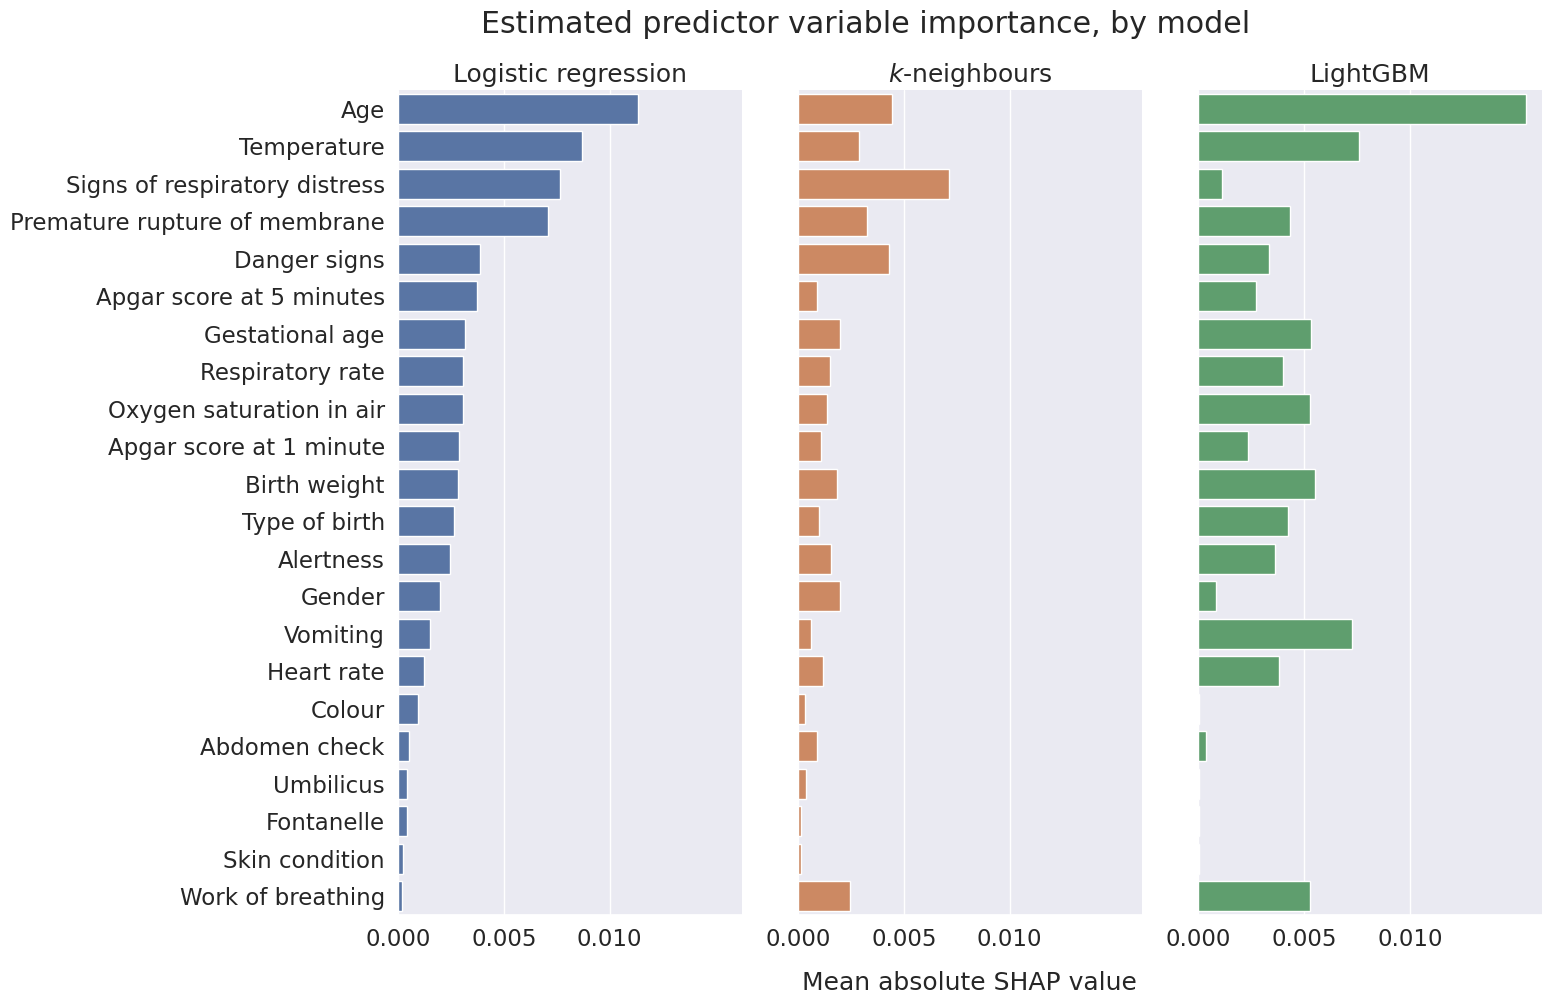

In [18]:
# vars_in_order = shap_df.groupby('expanded_var')['Mean absolute SHAP value'].mean().sort_values(ascending=False).index
vars_in_order = shap_df.loc[shap_df['label'] == 'lr'].sort_values('Mean absolute SHAP value', ascending=False)['expanded_var'].values

g = sns.catplot(
    shap_df, 
    x='Mean absolute SHAP value', 
    y='expanded_var', 
    hue='expanded_label', 
    order=vars_in_order, 
    col='expanded_label', 
    kind='bar', 
    sharex='row',
    height=10, 
    aspect=9/16
)
g.set_titles(col_template='{col_name}')
g.set_ylabels('')
g.set_xlabels('')
g.fig.text(0.4675, 0.0, 'Mean absolute SHAP value')
g.fig.subplots_adjust(top=0.9, bottom=0.075)
g.fig.suptitle('Estimated predictor variable importance, by model')
g._legend.remove()
g.set(xticks=[0, 0.005, 0.01])
g.savefig('./output/shapley.png')


Not in paper, comparison of logistic regression coefficient values with SHAP values

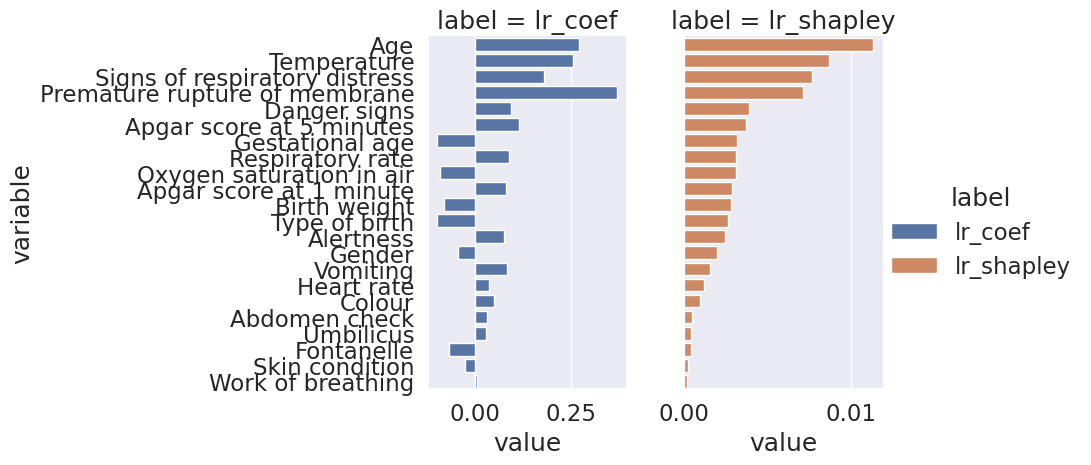

In [19]:
coef_rows = []
for colname, coef in zip(lr_manager.X_train.columns, lr_manager.best_clf.coef_[0]):
    coef_rows.append({
        'variable': expand_var_name(colname), 
        'value': coef,
        'label': 'lr_coef'
    })
coef_df = pd.concat([
    pd.DataFrame(coef_rows), 
    pd.DataFrame({
        'label': 'lr_shapley',
        'variable': [expand_var_name(x) for x in lr_manager.X_train.columns],
        'value': lr_manager.shap_values.abs.mean(axis=0).values
    })
])
sns.catplot(coef_df, x='value', y='variable', hue='label', order=vars_in_order, col='label', sharex=False, kind='bar')

In [20]:
shap_df.groupby('label')['Mean absolute SHAP value'].min()

label
knn    0.000119
lgb    0.000062
lr     0.000194
Name: Mean absolute SHAP value, dtype: float64

Quantify tendency of LGB SHAP values to approach zero faster than other two models

In [68]:
shap_df.groupby('label')['Mean absolute SHAP value'].apply(lambda grp: (grp < 0.0001).sum())

label
knn    0
lgb    4
lr     0
Name: Mean absolute SHAP value, dtype: int64

In [70]:
shap_df.to_csv('./output/shap_df.csv', index=False)

Tuned model hyperparameter values:

In [23]:
knn_manager.best_clf

KNeighborsClassifier(n_jobs=-1, n_neighbors=460)

In [24]:
lgb_manager.best_clf

LGBMClassifier(max_depth=7, min_data_in_leaf=24,
               min_split_gain=0.09859137037842475, num_leaves=6,
               objective='binary', reg_alpha=2.640056351547458, verbosity=-1)

Statistical significance test for (normalized) variables in training and test datasets:

In [25]:
mannwhitneyu(lgb_manager.X_train, lgb_manager.X_test).pvalue

array([0.26782899, 0.32767704, 0.89391563, 0.68573434, 0.35715353,
       0.80291407, 0.88721788, 0.54907146, 0.70517996, 0.73825054,
       0.70326868, 0.53988125, 0.83314014, 0.76486259, 0.47845717,
       0.81107568, 0.13172527, 0.04959979, 0.47612588, 0.51982989,
       0.46377551, 0.56121897])

In [26]:
for label in shap_df['label'].unique():
    print(label)
    tmp_df = shap_df.loc[shap_df['label'] == label]
    print(tmp_df.sort_values('Mean absolute SHAP value', ascending=False).head(10)[['variable', 'Mean absolute SHAP value']])

lr
       variable  Mean absolute SHAP value
2           Age                  0.011321
9   Temperature                  0.008704
12      Signsrd                  0.007678
6     Romlength                  0.007109
11  Dangersigns                  0.003866
1        Apgar5                  0.003731
7     Gestation                  0.003154
17           Rr                  0.003096
4       Satsair                  0.003086
0        Apgar1                  0.002868
knn
       variable  Mean absolute SHAP value
12      Signsrd                  0.007138
2           Age                  0.004451
11  Dangersigns                  0.004289
6     Romlength                  0.003271
9   Temperature                  0.002881
13          Wob                  0.002469
7     Gestation                  0.002002
3        Gender                  0.001970
8   Birthweight                  0.001860
14     Activity                  0.001567
lgb
       variable  Mean absolute SHAP value
2           Age        

### Second stage of analysis, LightGBM only:

We investigate here whether the decision to "reduce cardinality" in the predictors, e.g. combine all values for skin condition (rash, boils, etc) into one value ("condition present") makes a difference to the model. The result that it does not is omitted from the paper for simplicity. 

In [31]:
full_dataset_lgb_managers = []
for reduce_cardinality in [True, False]:
    full_dataset_lgb_manager = ModelManager('lgb',
                                            y_label,
                                            data_filepath,
                                            columns_of_interest,
                                            seed,
                                            LGBMClassifier,
                                            n_trials,
                                            search_space=lgbm_search_space,
                                            reduce_cardinality=reduce_cardinality,
                                            scale='none',
                                            clf_params={'objective': 'binary', 'verbosity': -1})

    full_dataset_lgb_manager.run()
    full_dataset_lgb_managers.append(full_dataset_lgb_manager)

18345


[I 2025-03-06 16:52:02,541] A new study created in memory with name: no-name-109e65b2-e659-456b-aa96-7d2b0eb335f7


18345


[I 2025-03-06 16:52:18,203] Trial 0 finished with value: 0.6879160751079455 and parameters: {'max_depth': 15, 'min_data_in_leaf': 26, 'reg_alpha': 1.962015483094881, 'min_split_gain': 0.9731394126864131, 'num_leaves': 24}. Best is trial 0 with value: 0.6879160751079455.
[I 2025-03-06 16:52:27,041] Trial 1 finished with value: 0.6994330951234516 and parameters: {'max_depth': 8, 'min_data_in_leaf': 17, 'reg_alpha': 0.5130602377641913, 'min_split_gain': 0.5280290919249422, 'num_leaves': 3}. Best is trial 1 with value: 0.6994330951234516.
[I 2025-03-06 16:52:27,379] Trial 2 finished with value: 0.6976207805685617 and parameters: {'max_depth': 18, 'min_data_in_leaf': 27, 'reg_alpha': 7.117959924096684, 'min_split_gain': 0.6391733764332602, 'num_leaves': 28}. Best is trial 1 with value: 0.6994330951234516.
[I 2025-03-06 16:52:33,495] Trial 3 finished with value: 0.6926441661079892 and parameters: {'max_depth': 17, 'min_data_in_leaf': 19, 'reg_alpha': 2.842516398600057, 'min_split_gain': 0.81

18345


[I 2025-03-06 16:58:41,271] A new study created in memory with name: no-name-407aa0f1-d67f-4093-86c1-2da8762ce70f


18345


[I 2025-03-06 16:58:48,185] Trial 0 finished with value: 0.6948654038491563 and parameters: {'max_depth': 2, 'min_data_in_leaf': 20, 'reg_alpha': 5.283459018582516, 'min_split_gain': 0.8336033563319569, 'num_leaves': 16}. Best is trial 0 with value: 0.6948654038491563.
[I 2025-03-06 16:58:53,059] Trial 1 finished with value: 0.6954133752043998 and parameters: {'max_depth': 12, 'min_data_in_leaf': 16, 'reg_alpha': 6.321934403108891, 'min_split_gain': 0.4309772939477865, 'num_leaves': 9}. Best is trial 1 with value: 0.6954133752043998.
[I 2025-03-06 16:58:53,820] Trial 2 finished with value: 0.6942897029891613 and parameters: {'max_depth': 18, 'min_data_in_leaf': 22, 'reg_alpha': 2.8670484691553213, 'min_split_gain': 0.05295547564216596, 'num_leaves': 4}. Best is trial 1 with value: 0.6954133752043998.
[I 2025-03-06 16:58:59,833] Trial 3 finished with value: 0.6909738903969067 and parameters: {'max_depth': 17, 'min_data_in_leaf': 10, 'reg_alpha': 6.551588451064695, 'min_split_gain': 0.18

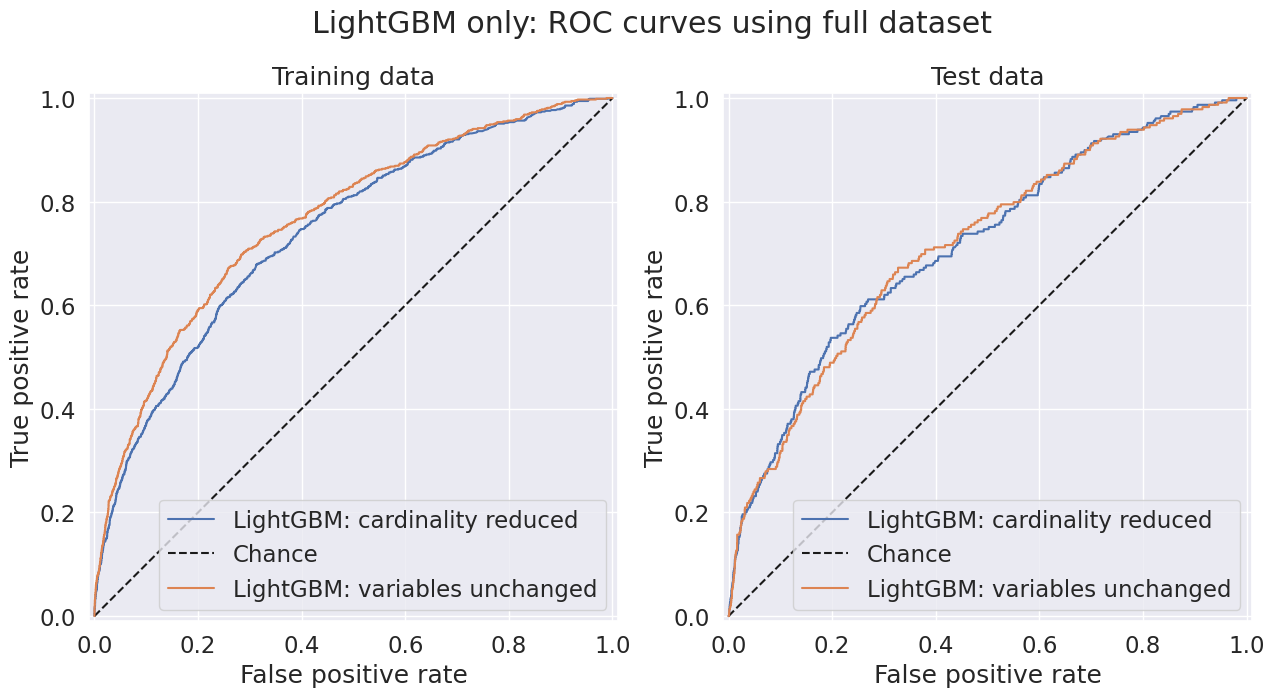

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
training_data_ax = axes[0]
test_data_ax = axes[1]

for mm in full_dataset_lgb_managers:
    if mm.reduce_cardinality:
        label = 'LightGBM: cardinality reduced'
        plot_chance_level = True
    else:
        label = 'LightGBM: variables unchanged'
        plot_chance_level = False
    RocCurveDisplay.from_predictions(mm.y_train,
                                     mm.best_clf.predict_proba(mm.X_train)[:,1], 
                                     ax=training_data_ax, 
                                     label=label,
                                     plot_chance_level=plot_chance_level,
                                     chance_level_kw={'label':'Chance'})
    RocCurveDisplay.from_predictions(mm.y_test,
                                     mm.best_clf.predict_proba(mm.X_test)[:,1], 
                                     ax=test_data_ax, 
                                     label=label,
                                     plot_chance_level=plot_chance_level,
                                     chance_level_kw={'label':'Chance'})

for ax in axes:    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    # auprc_axes[idx].legend(loc='upper right')
training_data_ax.title.set_text('Training data')
test_data_ax.title.set_text('Test data')
# plt.subplots_adjust(hspace=0.25, wspace=0.3)
fig.suptitle('LightGBM only: ROC curves using full dataset', y=0.93)
plt.savefig('./output/lgb_only_v4.png', bbox_inches='tight', pad_inches=0.5)

Taking the model which was trained on the full dataset, without simplification of categorical variables, to be our top-performing model, we are able to obtain the following performance metrics:

In [33]:
full_dataset_model_comparison_rows = []
for mm in full_dataset_lgb_managers:
    if mm.reduce_cardinality:
        label = 'LightGBM: cardinality reduced'
    else:
        label = 'LightGBM: variables unchanged'
    full_dataset_model_comparison_rows.append({
        'label': label,
        'metric': 'auroc',
        'type': 'train',
        'test_set_score': roc_auc_score(mm.y_train, mm.best_clf.predict_proba(mm.X_train)[:,1])
    })
    full_dataset_model_comparison_rows.append({
        'label': label,
        'metric': 'auprc',
        'type': 'train',
        'test_set_score': average_precision_score(mm.y_train, mm.best_clf.predict_proba(mm.X_train)[:,1])
    })
    full_dataset_model_comparison_rows.append({
        'label': label,
        'metric': 'auroc',
        'type': 'test',
        'test_set_score': roc_auc_score(mm.y_test, mm.best_clf.predict_proba(mm.X_test)[:,1])
    })
    full_dataset_model_comparison_rows.append({
        'label': label,
        'metric': 'auprc',
        'type': 'test',
        'test_set_score': average_precision_score(mm.y_test, mm.best_clf.predict_proba(mm.X_test)[:,1])
    })
full_dataset_model_comparison_df = pd.DataFrame(full_dataset_model_comparison_rows)
full_dataset_model_comparison_df

,label,metric,type,test_set_score
0,LightGBM: cardinality reduced,auroc,train,0.740533
1,LightGBM: cardinality reduced,auprc,train,0.170517
2,LightGBM: cardinality reduced,auroc,test,0.715233
3,LightGBM: cardinality reduced,auprc,test,0.146090
4,LightGBM: variables unchanged,auroc,train,0.764958
5,LightGBM: variables unchanged,auprc,train,0.199734
6,LightGBM: variables unchanged,auroc,test,0.715345
7,LightGBM: variables unchanged,auprc,test,0.142498


In [34]:
full_dataset_model_comparison_df.round(decimals=3).to_csv('./output/full_dataset_model_comparison_df.csv', index=False)

In [35]:
delong_dfs = []
for mm in full_dataset_lgb_managers:
    print(mm.name)
    print(mm.best_clf.predict_proba(mm.X_test)[:,-1])
    delong_dfs.append(pd.DataFrame({
        'name': mm.name,
        'reduce_cardinality': mm.reduce_cardinality,
        'y_test': mm.y_test.astype(int),
        'y_pred': mm.best_clf.predict_proba(mm.X_test)[:,-1]
    }))
delong_df = pd.concat(delong_dfs)
delong_df
delong_df.to_csv('./full_dataset_lgb_delong_df.csv', index=False)

lgb
[0.04324396 0.02116439 0.04083479 ... 0.04422262 0.03743996 0.05595449]
lgb
[0.04035768 0.01818477 0.04448669 ... 0.0413638  0.04486066 0.05568209]


In [36]:
top_mm = full_dataset_lgb_managers[0]
assert top_mm.name == 'lgb' and top_mm.reduce_cardinality

Final stage LightGBM tuned hyperparameter values:

In [89]:
top_mm.best_clf

LGBMClassifier(max_depth=5, min_data_in_leaf=23,
               min_split_gain=0.3507101701928358, num_leaves=3,
               objective='binary', reg_alpha=1.696372429012575, verbosity=-1)

In [85]:
fpr, tpr, thresholds = roc_curve(top_mm.y_test, top_mm.best_clf.predict_proba(top_mm.X_test)[:,1])
thresholds_df = pd.DataFrame({
    'sensitivity': tpr,
    'specificity': 1 - fpr,
    'threshold': thresholds
})
who_min_sensitivity = 0.85
who_preferred_sensitivity = 0.95
youden_threshold = thresholds[np.argmax(tpr - fpr)]
who_df = pd.concat([
    thresholds_df.loc[thresholds_df['threshold'] == youden_threshold].assign(label="Youden's index"),
    thresholds_df.loc[thresholds_df['sensitivity'] >= who_min_sensitivity].head(1).assign(label='WHO minimum sensitivity'),
    thresholds_df.loc[thresholds_df['sensitivity'] >= who_preferred_sensitivity].head(1).assign(label='WHO preferred sensitivity')
])[['label', 'sensitivity', 'specificity', 'threshold']]
ppv = []
npv = []
for threshold in who_df['threshold'].values:
    tn, fp, fn, tp = np.ravel(confusion_matrix(top_mm.y_test, top_mm.best_clf.predict_proba(top_mm.X_test)[:,1] > threshold))
    ppv.append(tp / (tp + fp))
    npv.append(tn / (tn + fn))
who_df['ppv'] = ppv
who_df['npv'] = npv
who_df['lrp'] = who_df['sensitivity'] / (1 - who_df['specificity'])
who_df['lrn'] = (1 - who_df['sensitivity']) / who_df['specificity']
who_df

,label,sensitivity,specificity,threshold,ppv,npv,lrp,lrn
346,Youden's index,0.598253,0.745296,0.052024,0.109237,0.972172,2.348818,0.539043
776,WHO minimum sensitivity,0.851528,0.378614,0.033771,0.066850,0.979228,1.370370,0.392145
958,WHO preferred sensitivity,0.951965,0.191143,0.025807,0.058006,0.985816,1.176926,0.251304


In [86]:
who_df.drop('threshold', axis='columns').round(decimals=3).to_csv('./output/metrics.csv', index=False)

Bonus SHAP plots, not reported in paper:

In [44]:
explainer = shap.Explainer(top_mm.best_clf)
shap_values = explainer(top_mm.X_test)

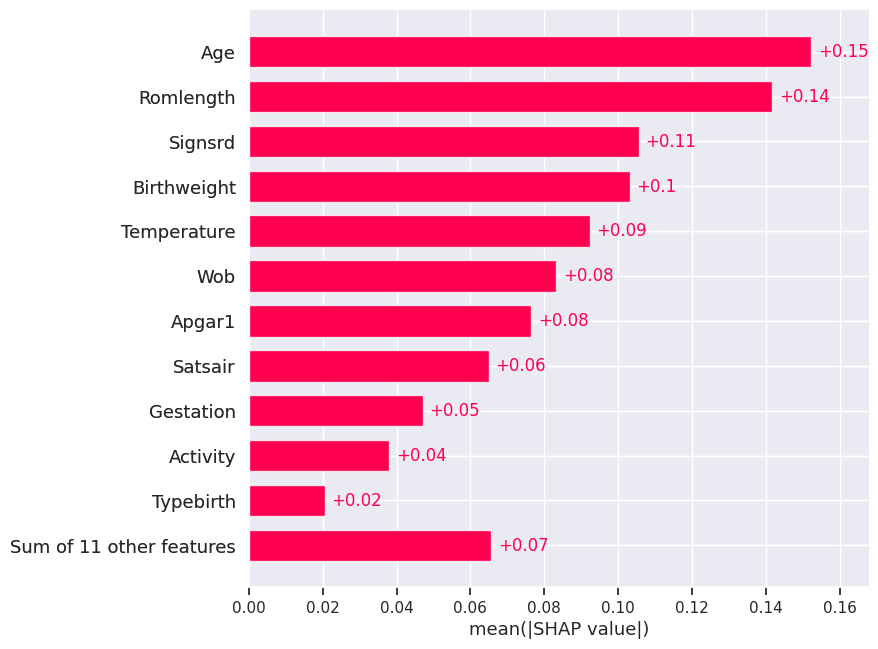

In [45]:
shap.plots.bar(shap_values, max_display=12)

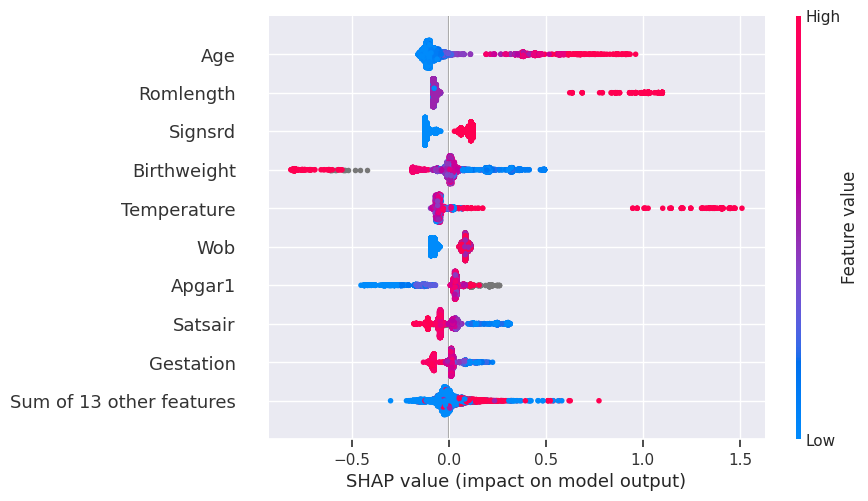

In [46]:
shap.plots.beeswarm(shap_values)

Final stage significance test for differences between training and test data:

In [50]:
mannwhitneyu(top_mm.X_train, top_mm.X_test, nan_policy='omit').pvalue

array([0.93671916, 0.87013228, 0.25137843, 0.98475851, 0.19496658,
       0.83993179, 0.73140486, 0.60817665, 0.40128003, 0.23917377,
       0.37564564, 0.87369583, 0.58226883, 0.83003632, 0.35766904,
       0.27743306, 0.42994088, 0.15413799, 0.08248976, 0.20428741,
       0.51505641, 0.64279761])

Generate table 2:

In [75]:
table_two_rows = []
for stage, mm in zip(['model comparison', 'lightgbm only'], [lgb_manager, top_mm]):
    N = len(mm.y_train) + len(mm.y_test)
    for ds_label, ds in zip(['train', 'test'], [mm.y_train, mm.y_test]):
        table_two_rows.append({
            'stage': stage,
            'dataset': ds_label,
            'n': len(ds),
            'pct_n': len(ds) / N * 100,
            'outcomes': ds.sum(),
            'pct_outcomes': ds.sum() / len(ds) * 100
        })
pd.DataFrame(table_two_rows)

,stage,dataset,n,pct_n,outcomes,pct_outcomes
0,model comparison,train,12446,74.998494,604,4.852965
1,model comparison,test,4149,25.001506,201,4.844541
2,lightgbm only,train,13758,74.995912,688,5.000727
3,lightgbm only,test,4587,25.004088,229,4.992370
